In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from numpy import pi as npi
from scipy.signal.windows import tukey

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Sine-Gaussian Wavelets
### aka Morlet-Gabor wavelets

We will do a simple matched filter example using sine-gaussian waveforms. This provides a generic example to understand the mechanics of matched filtering, and you can work through a more astrophysical gravitational-wave example later. 

Sine-Gaussian wavelets are waves that are constrained in frequency and time. In time domain, we just get them by multiplying a sine or a cosine wave with a Gaussian

$$\Psi(t) = \exp \left(-\frac{(t - t_0)^2}{\tau^2} \right) \cos \left(2 \pi f_0 (t - t_0) + \phi_0 \right)$$


The nice properties of a Gaussian under a Fourier transform (a Fourier transform of a Gaussian is again a Gaussian) means that they basically have the same functional form in the frequency domain

$$\Psi(f) = \frac{\sqrt{\pi}A\tau}{2} \exp \left(- \pi^2 \tau^2(f - f_0)^2 \right) \,  \exp \left(- 2 \pi i (f + f_0) t_0) + \phi_0 \right)$$




### Lets define our sine-Gaussian wavelets

In [2]:
def mgwavelet_td(t, A, f0, t0, tau=0.5):

    exp_term = np.exp(-(t - t0)**2 / tau**2)
    wave_term = np.cos(2*npi*f0*(t - t0))

    return A * exp_term * wave_term

def mgwavelet_fd(f, A, f0, t0, tau=0.5):

    exp_term = np.exp(-npi**2 * tau[None, :]**2 * \
                      (f[:, None]-f0[None, :])**2)
     
    wave_term = np.exp(-2j*npi*(f[:, None, None]- \
                                f0[None, :, None])*t0 )
    
    return 0.5*np.sqrt(npi)*A[None,:, None]*tau[None, :, None] * \
            exp_term[:, :, None] * wave_term


### Lets create some SG wavelets and add them to white time-domain data. We will also take an FFT of our data to compare against the frequency domain waveform

In [3]:
A_inj, f0_inj, t0_inj, tau_inj= 2.5, 2.1, 4.3, 0.5
noise_sigma = 0.75
times = np.arange(0, 8, 0.01)
fs = 1.0/(times[1] - times[0]) #sampling frequency
freqs = np.fft.rfftfreq(times.size, d=times[1]-times[0])

data = mgwavelet_td(times, A_inj, f0_inj, t0_inj) + \
        noise_sigma*np.random.normal(size=times.size)

# Lets take the FFT of our data as we will be mainly working in the frequency domain. 
window = np.hanning(times.size)
window_fact = np.sqrt(2 / np.mean(window**2))
fdata = window_fact * np.fft.rfft(data*window)/fs/np.sqrt(times[-1])

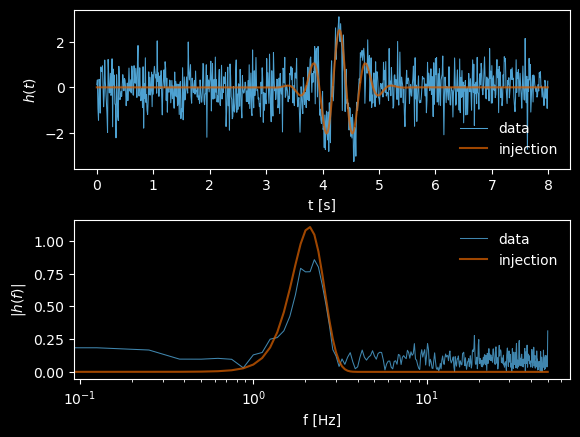

In [4]:
## Lets make some plots of out data to check that it looks ok
fig, ax = plt.subplots(nrows=2, ncols=1)

# time domain plot
ax[0].plot(times, data, label='data', alpha=0.9, color='#56B4E9', lw=0.75)
ax[0].plot(times, mgwavelet_td(times, A=A_inj, f0=f0_inj, t0=t0_inj), 
           label='injection', color='#D55E00', alpha=0.75)
ax[0].legend(frameon=False)
ax[0].set_xlabel('t [s]')
ax[0].set_ylabel('$h(t)$')
# freq domain plot
ax[1].plot(freqs, np.abs(fdata), label='data', alpha=0.75, color='#56B4E9', lw=0.75)
ax[1].plot(freqs, np.abs(mgwavelet_fd(freqs, A=np.array([A_inj]), 
                                      f0=np.array([f0_inj]), 
                                      t0=np.array([t0_inj]), 
                                     tau=np.array([tau_inj])))[:, 0, 0], label='injection', alpha=0.75, color='#D55E00')
ax[1].legend(frameon=False)
ax[1].set_xscale('log')
ax[1].set_xlabel('f [Hz]')
ax[1].set_ylabel('$|h(f)|$')

plt.subplots_adjust(hspace=0.32)

In [5]:
fig.show()

/var/folders/q_/4fb27_xd0c72q79_qtw8qtjh0000gn/T/ipykernel_81762/89474557.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


### Remembering the definition of SNR

Recall that the matched filter SNR is
$$S/N = \frac{\langle u | h \rangle}{\langle u | u \rangle^{1/2}}$$
Where $u$ is the filter. The SNR is maximized when $u\propto h$ as we learned in class. Let's unpack the terms. First recall that the inner product we defined is:
$$\langle a | b \rangle = 4{\rm Re}\int_0^\infty \frac{\tilde{a}(f)\tilde{b}^*(f)}{S_n(f)}df$$
Where the $\sim$ symbol denotes the fourier transform.
Since we don't know exactly when the signal occurs in the data, $u$ is a function of the relative time lag $\tau$ between the start of the data and the start of the template. Therefore, the SNR is also a function of $\tau$. Thankfully, we can make use of some Fourier theory to make it easy to find the time lag of the matched filter!



**Getting the SNR time series**

Recall that if the Fourier transform $\mathcal{F}[u(\tau=0)] = \tilde{u}(f)$ then $\mathcal{F}[u(\tau)] = \tilde{u}(f)e^{2\pi i f\tau}$. Let's plug this into the numerator term of our SNR expression:
$$ \langle u(\tau) | h \rangle  = 4{\rm Re}\int_0^\infty \frac{\tilde{u}(f)\tilde{h}^*(f)e^{2\pi i f\tau}}{S_n(f)}df = 4{\rm Re}\int_0^\infty \frac{\tilde{u}(f)}{S_n(f)^{1/2}}\frac{\tilde{h}^*(f)}{S_n(f)^{1/2}}e^{2\pi i f\tau}df = 4{\rm Re}\int_0^\infty \tilde{u}_{w}(f)\tilde{h}_w^*(f)e^{2\pi i f\tau}df$$
Here we've defined $\tilde{u}_{w}(f) = \frac{\tilde{u}(f)}{S_n(f)^{1/2}}$ and similarly for $\tilde{h}_w$. The $w$ subscripts denoted the *whitened* frequencies series. Whitening just means dividing out the amplitude spectral density of the noise, which upweights (downweights) the signal at frequencies at which there is low (high) noise. You'll also note that this integral above is just the inverse Fourier transform of $\tilde{u}_{w}(f)\tilde{h}_w^*(f)$! So all we need to do to get the numerator term as a function of $\tau$ is calculate the whitened frequency series for both the template and the data, multiply them, and then take the inverse Fourier transform. What we'll be left with is the complex SNR time series. We can take the absolute value of this to get the SNR vs time lag.

In [6]:
def snr_time_series(fdata, ftemplate, n, df):
    """
    Args
    ----
    fata: data in frequency domain
    ftemplate: template in frequency domain
    n: length of returned inner product series
    df: frequency spacing
    
    Returns : SNR time series
    """
    
    # < u | h>
    S_f = np.einsum('i,ijk->ijk', fdata, np.conj(ftemplate))
    S = 4.*np.real(np.fft.irfft(S_f, n=n, axis=0))*df
    
    # <u | u>
    N = np.sqrt(np.trapz(np.abs(ftemplate)**2, dx=df, axis=0))
    
    return  S/N

### we pad our data to ensure some good behaviors

In [7]:
def determine_pad_to_length(series):
    """
    Take in a time series and return the lowest power of two that is
    larger than the length
    """
    return int(2**np.ceil(np.log2(len(series))))



def pad(strain,times,pad_to_length):
    """
    Parameters
    ----------
    strain: array
        strain time series
    times: array
        times associated with the strain time series
    pad_to_length: int
        length of outputted padded vectors
        
    Returns
    -------
    padded_strain: array
    padded_times: array
    """
    orig_len = len(times)
    padded_strain = np.pad(strain,(0,pad_to_length-orig_len))
    padded_times = np.pad(times,(0,pad_to_length-orig_len),mode='linear_ramp',
                          end_values=(0,np.diff(times)[0]*pad_to_length))

    return padded_strain, padded_times

### Now we put it all together: lets calculate the SNR time series. We get back the SNR time series, maximized across our template bank along with the optimal parameters

In [8]:
def mgwavelet_matched_filter(data, times, window_dur):

    fs = 1/(times[1] - times[0])
    nyquist = fs/2    
    
    mc_size = int(1e4)

    A_arr = np.random.uniform(low=0.1, high=5, size=mc_size)
    f0_arr = np.random.uniform(low=0.1, high=5, size=mc_size)
    tau_arr = np.random.uniform(low=0.1, high=2.0, size=mc_size)
    
    
    padded_data, padded_times = pad(data,times, 
                                    determine_pad_to_length(times))
    
    
    # Lets take the FFT of our data as we will be mainly working in the frequency domain. 
    freqs = np.fft.rfftfreq(padded_times.size, d=padded_times[1] - padded_times[0])

    window = tukey(padded_times.size, alpha=0.2)
    window_fact = np.sqrt(2 / np.mean(window**2))

    fdata = window_fact * np.fft.rfft(padded_data*window)/fs/np.sqrt(padded_times[-1])
    
    
    template = mgwavelet_fd(freqs, 
                            A=A_arr, 
                            f0=f0_arr, 
                            t0=0, 
                            tau=tau_arr)

    
    SNR = snr_time_series(fdata, 
                          template, 
                          n=padded_times.size, 
                          df=freqs[1] - freqs[0])

    SNR_opt = np.max(SNR, axis=1)
    
    #import pdb; pdb.set_trace()
    opt_args = np.argmax(np.max(SNR, axis=0))
    opt_t0 = padded_times[np.argmax(SNR_opt)]

    opt_filters = {'f0':f0_arr[opt_args], 
                  'A':A_arr[opt_args], 
                  'tau':tau_arr[opt_args],}
            
    return SNR_opt, opt_filters, opt_t0, padded_times

## Lets plot the SNR time series. Remember that our SNR  calculation is missing a fact of the white noise PSD  

Text(0, 0.5, '$h(t)$')

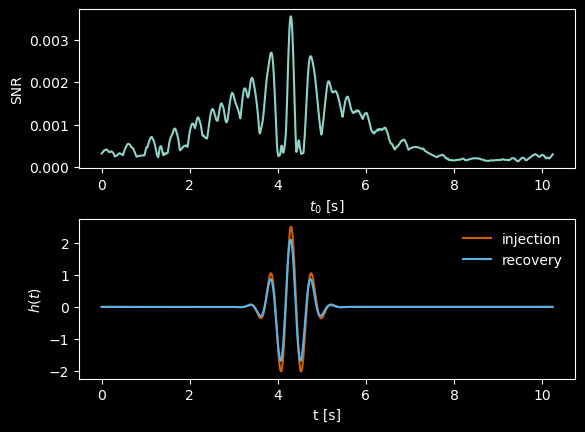

In [9]:
### ------------- run matched filter
SNR_opt, opt_filters, opt_t0, padded_times = mgwavelet_matched_filter(data, 
                                                                      times, 
                                                                      times[-1])
opt_idx = np.argmax(SNR_opt)



fig, ax = plt.subplots(nrows=2, ncols=1)
plt.subplots_adjust(hspace=0.32)
ax[0].plot(padded_times, SNR_opt)
ax[0].set_xlabel('$t_0$ [s]')
ax[0].set_ylabel('SNR')

ax[1].plot(padded_times, mgwavelet_td(padded_times, 
                                      A=A_inj, 
                                      f0=f0_inj, 
                                      t0=t0_inj), 
           label='injection', color='#D55E00')

ax[1].plot(padded_times, mgwavelet_td(padded_times, A=opt_filters['A'], 
                                    f0=opt_filters['f0'], 
                                    t0=opt_t0, 
                                    tau=opt_filters['tau']), 
           label='recovery', color='#56B4E9')



ax[1].legend(frameon=False)
ax[1].set_xlabel('t [s]')
ax[1].set_ylabel('$h(t)$')